### 1. Sekcja odczytywania danych, określania typów danych cech.

In [172]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.pipeline import Pipeline




### 2. Sekcja statystyki opisowej zmiennych kategorycznych

### Częstość występowania  unikatowych klas dla danej zmiennej.

In [173]:
def CreateFreqTable(Dataset:pd.DataFrame, CatFeature:str) ->  pd.DataFrame:
    """Funkcja dla każdej unikatowej klasy z cechy CatFeature wylicza liczbę jej wystapień.
    Wynikiem funkcji jest pandowska ramka danych, która zawiera trzy kolumny o nazwach odpowiednio: 'CatFeature', 'CatFeature_coded' oraz 'count'.
    Kolumna CatFeature_coded zawiera zakodowane nazwy klas w postaci liczb całkowitych. Taka forma ułatwia odczytywanie etykiet na wykresach.
    """

    FreqTable:pd.DataFrame = Dataset[CatFeature].value_counts(sort = True,) #Stwórz proste podsumowanie częstotliwości występowania klas.

    return  FreqTable

def PlotBarPlot(FreqTable:pd.Series, CatFeature:str, Showxlabels:bool = False) -> None:
    """Funkcja rysuje histogram na bazie tabelki histogramowej. 
    1) FreqTable  - Tabela częstotliwości kategori danej zmiennej kategorycznej
    2) CatFeature  - Cecha kategoryczna, której histogram chcemy narysować.
    3) Showxlabel - Zmienna typu bool. Jeżeli ustawiona na True, to etykietki osi Ox są wyświetlane."""
    
    plt.figure(figsize = (10,5)) #Stwórz płótno, na którym  będzie rysowany wykres
 
    axes = sns.barplot(x = FreqTable.index, y = FreqTable.values)


    axes.set_ylabel(f"Częstość klasy") #Ustaw etykietke pionowej osi.

    axes.set_xticklabels([]) #Usuń etykiety tyknięć na osi Ox.
    axes.spines[["top", "right"]].set_visible(False)

    axes.set_title(f"Histogram klas cechy {CatFeature}") #Ustaw tytuł wykresu.

    axes.set_ylim(0, 1.05*np.max(FreqTable))

    if Showxlabels == True:
        axes.set_xticklabels(labels = FreqTable.index)
        


def AggregateRarestClasses(Dataset:pd.DataFrame, CatFeature:str, Histogram:pd.Series, q_degree:float = 0.15) -> None:
    """Klasy, które występują rzadziej niż wartość wskaźnika threshold_frequent, dostaną etykietę "Other". Etykietki pozostałych klas nie ulegną zmian.
    1) Dataset - oryginalny zestaw danych.
    2) CatFeature - Zmienna kategoryczna, której rzadkie klasy chcemy zagregować.
    3) Histogram - Histogram cechy CatFeature
    4) q_degree  - stopień kwantylu. 
    Funkcja jedynie modyfikuje zestaw danych, dlatego właśnie nie zwraca żadnej wartości."""
    frequent_threshold:float = Histogram.quantile(q = q_degree)

    Dataset[CatFeature] = Dataset[CatFeature].apply(func = lambda categ: "Other" if Histogram[categ] < frequent_threshold else categ)

In [174]:
def DeleteFutileColsAndObs(Dataset:pd.DataFrame) -> pd.DataFrame:
    """Funkcja usuwa quasi-identyfikator zmienną oraz jedną obserwację, która zawiera klasę, która występuje tylko raz."""

    Dataset.drop(columns = ["Model"], inplace = True)

    Dataset = Dataset.query('`Fuel Type` != "N"')

    return Dataset
    

### 3. Cechy numeryczne ciągłe.

### Badanie zależności poziomu emisji dwutlenku węgla w zależności od wielkości spalania paliwa na autostradzie i w mieście dla różnych typów paliwa.
### Dodatkowo zbadamy współczynniki korelacji między tymi cechami ciągłymi.



In [175]:
def ComputeAndDrawCorrelationMatrix(Dataset:pd.DataFrame, FloatFeatures: list[str]) -> None:
    """Funkcja wylicza macierz korelaji dla zmiennych z listy FloatFeatures. Ponadto, rysuje tę macierz korelacji na wykresie, aby można
    było sobie uzmysłowić relacje między zmiennymi
    1) Dataset - oryginalny zbiór danych
    2) FloatFeatures  - zmienne ciągłe"""
    CorrMatrix:pd.DataFrame =  Dataset[FloatFeatures].corr(method = "pearson")

    plt.figure(figsize=(8, 6))

    sns.heatmap(CorrMatrix, annot=True, cmap='magma', vmin=-1, vmax=1)
    plt.title('Macierz korelacji dla zmiennych ciągłych')
    plt.show()



In [176]:
def Discretize(Dataset:pd.DataFrame, target_var:str, target_var_discr:str, bins:list[float]) -> None:
    """Funkcja dokonuje dyskretyzacji (interwalizacji) zmiennej docelowej ciągłej.
    1) Dataset - oryginalny zbiór danych.
    2) target_var - zmienna docelowa
    3) bins - kubełki, które określają granicę  interwałów zmiennej docelowej."""
    labels = [i for i in range(len(bins)+1)]
    bins = [-float("inf")] + bins + [float('inf')]


    discretized_feature = pd.cut(x = Dataset[target_var], 
                                 bins = bins, 
                                 labels = labels)

    Dataset[target_var_discr] = discretized_feature


In [177]:
def NarysujGęstości(Dataset:pd.DataFrame, FloatFeatures:list[str], Condition:str | None = None) -> None:
    """Ta funkcja rysuje wykresy gęstości prawdopodobieństwa dla zmiennych ciągłych.
    1) Dataset - oryginalny zestaw danych.
    2) FloatFeatures - zmienne numeryczne"""

    for floatFeature in FloatFeatures:
        figure = plt.figure(num = f"KDE_plot_{floatFeature}")
        axes = figure.add_subplot()

        sns.kdeplot(data = Dataset, x = floatFeature, ax = axes, hue = Condition)
        axes.set_title(f"Wykres gęstości prawdopodobieństwa dla zmiennej {floatFeature}")


def NarysujPudełko(Dataset:pd.DataFrame, FloatFeatures:list[str], Condition: str | None = None) -> None:
    """Ta funkcja rysuje wykresy pudełkowe dla zmiennych ciągłych.
    1) Dataset - oryginalny zestaw danych.
    2) FloatFeatures - zmienne numeryczne"""

    for floatFeature in FloatFeatures:
        figure = plt.figure(num = f"BOX_plot_{floatFeature}")
        axes = figure.add_subplot()

        sns.boxplot(Dataset, x = floatFeature, hue = Condition)

        axes.set_title(f"Wykres pudełkowy dla zmiennej {floatFeature}")


def NarysujSkrzypce(Dataset:pd.DataFrame, FloatFeatures:list[str], Condition:str | None = None) -> None:
     """Ta funkcja rysuje wykresy skrzypcowe dla zmiennych ciągłych.
    1) Dataset - oryginalny zestaw danych.
    2) FloatFeatures - zmienne numeryczne
    3) Condition = Pewna zmienna kategoryczna, za pomocą której stworzą się warunkowe wykresy skrzypcowe ze względu przynależność do klasy."""

     for floatFeature in FloatFeatures:
        figure = plt.figure(num = f"VIOLIN_plot_{floatFeature}")
        axes = figure.add_subplot()

        sns.violinplot(Dataset, x = floatFeature, hue = Condition)

        axes.set_title(f"Wykres skrzypcowy dla zmiennej {floatFeature}")

        axes.legend([])

        axes.grid(True, alpha = 0.6)
        axes.spines[['top','right']].set_visible(False)



def NarysujWykresParowy(Dataset:pd.DataFrame,  Condition: str | None = None) -> None:
    """Funkcja rysuje wykres parowy dla wszystkich par zmiennych ciągłych.
    """
    sns.pairplot(Dataset, hue = Condition,diag_kind = "kde")



In [178]:
from sklearn.linear_model import LogisticRegression

# Definicja modeli z hiperparametrami
Models = {
    "DrzewkoDecyzyjne": DecisionTreeClassifier(criterion="gini", splitter="best", min_samples_split=10), 
    "LasLosowy": RandomForestClassifier(n_estimators=15, criterion='gini'), 
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "RegresjaLiniowa": MultiOutputRegressor(estimator = LinearRegression()),
   # "RegresjaLogistyczna": LogisticRegression()
}                
# #Słownik do przechowywania hiperparametrów modeli:
#  Models_hipparams = {"DrzewkoDecyzyjne":{"criterion":['gini','entropy'],
#                                        "splitter":['best','random'],
#                                        "min_samples_split":[2,3,4],
#                                         "min_samples_leaf":[2,3,4]},

#                     "LasLosowy":{"n_estimators":list(range(5, 50, 5)),
#                                   "criterion":['gini','entropy'],
#                                          "min_samples_split":[3,3,4],
#                                        "min_samples_leaf":[2,3,4]},
                                        
#                    "KNN": {"n_neighbors":list(range(1, 10, 1)),
#                             "p":[1,2]},
                            
#                         "RegresjaLogistyczna": {
#                             "penalty":['l1','l2'],
#                               "solver":['lbfgs','liblinear','newton-cg',],
#                               'multi_class':['auto','ovr','multinomial']
#                          }
#                              }

#Słownik do przechowywania hiperparametrów modeli:
Models_hipparams = {"DrzewkoDecyzyjne":{"criterion":['gini'],
                                        "splitter":['best'],
                                        "min_samples_split":[2],
                                        "min_samples_leaf":[2]},

                    "LasLosowy":{"n_estimators":list(range(5, 11, 5)),
                                  "criterion":['gini','entropy'],
                                        "min_samples_split":[2],
                                        "min_samples_leaf":[2]},
                                        
                    "KNN": {"n_neighbors":list(range(1, 3, 1)),
                            "p":[1]},
                            
                       # "RegresjaLogistyczna": {
                         #   "penalty":['l1','l2'],
                          #   "solver":['lbfgs'],
                           #  'multi_class':['auto']}, 
                             
                             "RegresjaLiniowa":{}
                            }



### Przygotowanie metody porównaczej.


In [179]:
import timeit 
dtypes = { "Make": "category", #Określ typ danych każdej cechy w ramce danych.
            "Model":"category",
            "Vehicle Class":"category",
            "Engine Size(L)":np.float64,
            "Cylinders":"category",
            "Transmission":"category",
            "Fuel Type":"category",
            "Fuel Consumption City (L/100 km)":np.float64,
            "Fuel Consumption Hwy (L/100 km)":np.float64,
            "Fuel Consumption Comb (L/100 km)":np.float64,
            "Fuel Consumption Comb (mpg)":np.float64,
            "CO2 Emissions(g/km)":np.float64}



class TrainTestModels():
    def __init__(self,  Filename:str, target_var:str, features:list[str], Models:dict[str, "estimator"], Models_hipparams:dict[str, dict],
                 n_splits:int = 5, train_size:float = 0.8, test_size:float = 0.2, 
                 Cat_predictors:list[str]  = [], Num_predictors:list[str] = [], PCA_predictors:list[str]= [], bins:list[int] = [150, 250]) -> None:
        """Konstruktor klasy, która trenuje modele. 
        Opis argumentów konstruktora:
        ---------
        Filename: str - Nazwa pliku, w której zawarta jest ramka danych typu pandas, która przechowuje zmienne objaśniające i zmienną objaśnianą. \n
        target_varc:str - Nazwa zmiennej objaśnianej. \n
        
        Cat_features:list[str] - Lista zmiennych kategorycznych. \n
        Num_features:list[str] - Lista zmiennych numerycznych. \n
        Cat_predictors:list[str] - Lista predyktorów kategorycznych. Predyktory kategoryczne nie zostały jeszcze zakodowane. \n
        Num_predictors:list[str] - Lista predyktorów numerycznych. \n
        PCA_predictors:list[str] - Lista predyktorów, które mają ulec analizie składowych głównych.

        Models:dict[str, "Estimator"] - Słownik, którego wartościami są instancje modeli, które chcemy wytrenować. Kluczami są umowne nazwy modeli. \n
        Models_hipparams:dict[str, dict] - Słownik, którego kluczami są umowne nazwy modeli, a którego wartościami są siatki parametrów danego modelu. \n
        
        n_splits:int - Liczba podziałów na zbiór treningowy i testowy. \n
        train_size:float - Odsetek obserwacji treningowych. \n

        test_size:float - Odsetek obserwacji testowych. \n
        ---------
        """
        self.Dataset:pd.DataFrame = self.ReadDataFrame(filename = Filename, sep = ';', dec_sep = ',') 

        self.features = features

        
        self.Cat_features:list[str] = [feature for feature in features if dtypes[feature] == "category"]
        self.Num_features:list[str] = [feature for feature in features if dtypes[feature] is np.float64]
        
     
        self.target_var:str = target_var
        self.bins:list[int] = bins

        self.Cat_predictors:list[str] = Cat_predictors
        self.Num_predictors:list[str] = Num_predictors
        self.PCA_predictors:list[str] = PCA_predictors

        self.Models:dict[str, "estimator"] = Models
        self.Models_hipparams:dict[str, dict] = Models_hipparams

        self.n_splits:int = n_splits
        self.train_size:float = train_size
        self.test_size:float = test_size


        self.PrzygotujRamkiPorownawcze()
        self.PrzygotujRamkiCzasowe()
        



    def ReadDataFrame(self, filename:str, 
                      sep:str =';', dec_sep:str =',') -> pd.DataFrame:
        """Odczytuje plik o nazwie filename i wprowadza dane z pliku do ramki danych."""
        global dtypes
    
        Dataset:pd.DataFrame = pd.read_csv(filename,
                            sep=sep, dtype = dtypes, decimal = dec_sep) #Wczytaj plik z danymi.



        return Dataset
    


    def CreateFreqTable(self, cat_feature:str) ->  pd.DataFrame:
        """Funkcja dla każdej unikatowej klasy z cechy CatFeature wylicza liczbę jej wystapień.
        Wynikiem funkcji jest pandowska ramka danych, która zawiera trzy kolumny o nazwach odpowiednio: 'CatFeature', 'CatFeature_coded' oraz 'count'.
        Kolumna CatFeature_coded zawiera zakodowane nazwy klas w postaci liczb całkowitych. Taka forma ułatwia odczytywanie etykiet na wykresach.
        """
        FreqTable:pd.DataFrame = self.Dataset[cat_feature].value_counts(sort = True,) #Stwórz wykres słupkowy częstości występowania klas.

        return  FreqTable

    def PlotBarPlot(self, FreqTable:pd.Series, cat_feature:str, Showxlabels:bool = False) -> None:
        """Funkcja rysuje histogram na bazie tabelki histogramowej. 
        1) FreqTable  - Tabela częstotliwości kategori danej zmiennej kategorycznej
        2) CatFeature  - Cecha kategoryczna, której histogram chcemy narysować.
        3) Showxlabel - Zmienna typu bool. Jeżeli ustawiona na True, to etykietki osi Ox są wyświetlane."""
        
        plt.figure(figsize = (10,5)) #Stwórz płótno, na którym  będzie rysowany wykres
    
        axes = sns.barplot(x = FreqTable.index, y = FreqTable.values)


        axes.set_ylabel(f"Częstość klasy") #Ustaw etykietke pionowej osi.

        axes.set_xticklabels([]) #Usuń etykiety tyknięć na osi Ox.
        axes.spines[["top", "right"]].set_visible(False)

        axes.set_title(f"Histogram klas cechy {cat_feature}") #Ustaw tytuł wykresu.

        axes.set_ylim(0, 1.05*np.max(FreqTable))

        if Showxlabels == True:
            axes.set_xticklabels(labels = FreqTable.index)
            


    def AggregateRarestClasses(self, cat_feature:str, Histogram:pd.Series, q_degree:float = 0.15) -> None:
        """Klasy, które występują rzadziej niż wartość wskaźnika threshold_frequent, dostaną etykietę "Other". Etykietki pozostałych klas nie ulegną zmian.
        1) Dataset - oryginalny zestaw danych.
        2) CatFeature - Zmienna kategoryczna, której rzadkie klasy chcemy zagregować.
        3) Histogram - Histogram cechy CatFeature
        4) q_degree  - stopień kwantylu. 
        Funkcja jedynie modyfikuje zestaw danych, dlatego właśnie nie zwraca żadnej wartości."""
        frequent_threshold:float = Histogram.quantile(q = q_degree)
        
                                    #- Dataset[cat_feature] to series.
        self.Dataset[cat_feature] = self.Dataset[cat_feature].apply(func = lambda categ: "Other" if Histogram[categ] < frequent_threshold else categ)
        

    def DeleteFutileColsAndObs(self) -> pd.DataFrame:
        """Funkcja usuwa quasi-identyfikator zmienną oraz jedną obserwację, która zawiera klasę, która występuje tylko raz."""

        self.Dataset.drop(columns = ["Model"], inplace = True)

        self.Dataset = self.Dataset.query('`Fuel Type` != "N"')

   
    def ComputeAndDrawCorrelationMatrix(self,) -> None:
        """Funkcja wylicza macierz korelaji dla zmiennych z listy FloatFeatures. Ponadto, rysuje tę macierz korelacji na wykresie, aby można
        było sobie uzmysłowić relacje między zmiennymi"""

        CorrMatrix:pd.DataFrame =  self.Dataset[self.Num_features].corr(method = "pearson")

        plt.figure(figsize=(8, 6))

        sns.heatmap(CorrMatrix, annot=True, cmap='magma', vmin=-1, vmax=1)
        plt.title('Macierz korelacji dla zmiennych ciągłych')
        plt.show()




    def DeleteFutileColsAndObs(self) -> None:
        """Funkcja usuwa quasi-identyfikator zmienną oraz jedną obserwację, która zawiera klasę, która występuje tylko raz."""

        self.Dataset.drop(columns = ["Model"], inplace = True)

        self.Dataset = self.Dataset.query('`Fuel Type` != "N"')



    def Discretize(self) -> None:
        labels:list[int] = [i for i in range(len(self.bins)+1)]
     

        discretized_feature:pd.Series = pd.cut(x = self.Dataset[self.target_var], 
                                    bins = self.bins, 
                                    labels = labels)
        

        self.Dataset[self.target_var_discr] = discretized_feature


    def NarysujGęstości(self, Condition:str | None = None) -> None:
        """Ta funkcja rysuje wykresy gęstości prawdopodobieństwa dla zmiennych ciągłych"""

        for float_feature in self.Num_features:
            figure = plt.figure(num = f"KDE_plot_{float_feature}")
            axes = figure.add_subplot()

            sns.kdeplot(data = self.Dataset, x = float_feature, ax = axes, hue = Condition)
            axes.set_title(f"Wykres gęstości prawdopodobieństwa dla zmiennej {float_feature}")



    def NarysujPudełko(self, Condition: str | None = None) -> None:
        """Ta funkcja rysuje wykresy pudełkowe dla zmiennych ciągłych.
        1) Dataset - oryginalny zestaw danych.
        2) FloatFeatures - zmienne numeryczne"""

        for float_feature in self.Num_features:
            figure = plt.figure(num = f"BOX_plot_{float_feature}")
            axes = figure.add_subplot()

            sns.boxplot(self.Dataset, x = float_feature, hue = Condition)

            axes.set_title(f"Wykres pudełkowy dla zmiennej {float_feature}")


    def NarysujSkrzypce(self,Condition:str | None = None) -> None:
        """Ta funkcja rysuje wykresy skrzypcowe dla zmiennych ciągłych.
        1) Dataset - oryginalny zestaw danych.
        2) FloatFeatures - zmienne numeryczne
        3) Condition = Pewna zmienna kategoryczna, za pomocą której stworzą się warunkowe wykresy skrzypcowe ze względu przynależność do klasy."""

        for float_feature in self.Num_features:
            figure = plt.figure(num = f"VIOLIN_plot_{float_feature}")
            axes = figure.add_subplot()

            sns.violinplot(self.Dataset, x = float_feature, hue = Condition)

            axes.set_title(f"Wykres skrzypcowy dla zmiennej {float_feature}")

            axes.legend([])

            axes.grid(True, alpha = 0.6)
            axes.spines[['top','right']].set_visible(False)


    def NarysujWykresParowy(self,   Condition: str | None = None) -> None:
        """Funkcja rysuje wykres parowy dla wszystkich par zmiennych ciągłych.
        """
        sns.pairplot(self.Dataset, hue = Condition ,diag_kind = "kde")





    def StatystykaOpisowaZmiennych(self,) -> None:
        for CatFeature in self.Cat_features:
            Histogram:pd.Series = CreateFreqTable(Dataset = self.Dataset,  #Znajdź histogram unikatowych klas dla zmiennej CatFeature.
                                        CatFeature = CatFeature) 
            
            self.AggregateRarestClasses(cat_feature = CatFeature, 
                                        Histogram = Histogram,
                                          q_degree = 0.15) #Zagreguj najrzadzsze klasy.

            Histogram_agg:pd.Series = CreateFreqTable(CatFeature = CatFeature) #Stwórz 

            self.PlotBarPlot(FreqTable = Histogram_agg,  
                             cat_feature = CatFeature, 
                             Showxlabels = False)
            
        
        
        #Kasowanie zbędnej obserwacji oraz quasi-id kolumny
        self.DeleteFutileColsAndObs()

        #Nadaj zdyskretyzowanej zmiennej docelowej nazwę.
        self.target_var_discr = self.target_var +"_disc"

        #Zdyskretyzuj zmienną objaśnianą.
        self.Discretize()

        
        #Narysuj wykresy charakteryzujące (relacje między zmiennymi) oraz (charakterystyki zmiennych).
        #RYSOWANIE MACIERZY KORELACJI DLA ZMIENNYCH NUMERYCZNYCH
        self.ComputeAndDrawCorrelationMatrix()

        #RYSOWANIE WYKRESÓW SKRZYPCOWYCH DLA ZMIENNYCH NUMERYCZNYCH
        self.NarysujSkrzypce()

        #Rysowanie wykresu parowego dla zmiennych numerycznych
        self.NarysujWykresParowy()

        
        
        target_var_discr_histogram:pd.Series = self.CreateFreqTable(cat_feature = self.target_var_discr) #Znajdź histogram tabelkowy dla zdyskretyzowanej zmiennej celu.

        self.PlotBarPlot(FreqTable = target_var_discr_histogram,   #Narysuj wykres słupkowy częstotliwości dla zmiennej celu zdyskretyzowanej.
                         cat_feature =  self.target_var_discr, 
                         Showxlabels = False)
        
    
        self.NarysujGęstości(Condition = self.target_var_discr)  #Wykresy gęstości warunkowe
        self.NarysujPudełko(Condition = self.target_var_discr) #Wykresy pudełkowe warunkowe

     
        self.NarysujWykresParowy(Condition = self.target_var_discr)

    
            


            
    def ComputeAccuracy(self, TrueVSPrediction:pd.DataFrame,) -> pd.DataFrame:
        """Funkcja wylicza metrykę dokładności, która stanowi podstawę oceny modeli.
        Opis argumentów:
        ---------
        TrueVSPrediction:pd.DataFrame - Ramka danych zawierająca etykiety prawdziwe oraz etykiety przewidziane. Kolumny tej ramki są indeksowane za pomocą trójki (model_name, split_indx, y_type)

        ---------

        Co funkcja zwraca?
        Ramke danych typu pandas wymiaru (self.n_splits,  len(self.Models)), w której  elementy (i, j) odpowiada wartości metryki dokładności dla i-tego podziału i j-tego modelu.
        """
        Models_name: list[str] = list(self.Models.keys())

        MetricComparison:np.ndarray = np.zeros(shape = [self.n_splits, len(Models_name)], 
                                    dtype = np.float64)
        
        
        for model_indx, model in enumerate(Models_name):
            for i in range(self.n_splits):
                y_true = TrueVSPrediction[(model, i, "True")]
                y_pred = TrueVSPrediction[(model, i, "Pred")]

                perfomance_metric = accuracy_score(y_true = y_true, 
                                                y_pred = y_pred)

                MetricComparison[i, model_indx] = perfomance_metric



        return pd.DataFrame(data = MetricComparison, 
                                        columns =  Models_name)





















    def ComputeMetric(self, TrueVSPrediction:pd.DataFrame, metric) -> pd.DataFrame:
        """Funkcja wylicza metrykę dokładności, która stanowi podstawę oceny modeli.
        Opis argumentów:
        ---------
        TrueVSPrediction:pd.DataFrame - Ramka danych zawierająca etykiety prawdziwe oraz etykiety przewidziane. Kolumny tej ramki są indeksowane za pomocą trójki (model_name, split_indx, y_type)

        ---------

        Co funkcja zwraca?
        Ramke danych typu pandas wymiaru (self.n_splits,  len(self.Models)), w której  elementy (i, j) odpowiada wartości metryki dokładności dla i-tego podziału i j-tego modelu.
        """
        Models_name: list[str] = list(self.Models.keys())

        MetricComparison = np.zeros(shape = [self.n_splits, len(Models_name)], 
                                    dtype = np.float64)
        
        for model_indx, model in enumerate(Models_name):
            for i in range(self.n_splits):
                y_true = TrueVSPrediction[(model, i, "True")]
                y_pred = TrueVSPrediction[(model, i, "Pred")]

                perfomance_metric =  metric(y_true = y_true,
                                                    y_pred = y_pred, 
                                                    average = "weighted",)

                MetricComparison[i, model_indx] = perfomance_metric


        return pd.DataFrame(data = MetricComparison, 
                                        columns = list(Models.keys()))



   






    def PlotConfussionMatrix(self, type:str = "bez strojenia") -> None:

        for model_name in self.Models.keys():
            if type == "bez strojenia":
                y_true:pd.Series = self.FactVsPrediction_untuned[(model_name, 0,  "True")]
                y_predicted:pd.Series = self.FactVsPrediction_untuned[(model_name, 0,  "Pred")]

            elif type == "ze strojeniem":
                y_true:pd.Series = self.FactVsPrediction_tuned[(model_name, 0,  "True")]
                y_predicted:pd.Series = self.FactVsPrediction_tuned[(model_name, 0,  "Pred")]
            else:
                raise ValueError("Nieprawidłowy rodzaj trenowania. Trenuje się albo bez strojenia albo ze szkoleniem")
            


            axes = plt.figure(num = f"{model_name}_conf_matrix_{type}").add_subplot()


            cos = ConfusionMatrixDisplay.from_predictions(y_true = y_true, y_pred = y_predicted, ax = axes, normalize = "true")
            axes.set_title(f"ConfMatrix dla  modelu {model_name}, wersja {type}")


    def PlotScoresCollectively(self, perfomance_df: pd.DataFrame, metric_name:str, type:str = "bez strojenia") -> None:
        figure = plt.figure()
        axes = figure.add_subplot()
            
        x_values:list[int] = list(range(0, self.n_splits))

        
        for model_name in Models.keys():
            axes.plot(x_values, 
                    perfomance_df[model_name])
            
        #Tablica, która przechowuje mediane wartości metryki dokładności w i-tym podziale.
        averages:list[float] = []
            
        for i in range(self.n_splits):
            averages.append(perfomance_df.iloc[i, :].median())
            
        axes.plot(x_values, averages, linestyle = "dashed", linewidth = 2)

        axes.legend(list(Models.keys()) +["MetricMedian"])
        axes.set_title(f"Dynamika zmian metryki {metric_name} dla modeli, wersja {type}")

        axes.set_xlabel("Numer iteracji") #Ustaw ładną etykietkę osi Ox
        axes.set_ylabel(f"{metric_name}") #Ustaw ładną etykietkę osi Oy

        axes.set_xticks(x_values) #Ustaw wartości tyknięć na osi Ox
            
        axes.grid(True) #Dodaj linie siatki

        axes.spines[['top','right']].set_visible(False) #Usuń kreskę górną oraz dolną.





    def PorównajZIBeZStrojeniaModel(self, Metric_comparison_untuned:pd.DataFrame, Metric_comparison_tuned:pd.DataFrame, metric_name:str,
                    ) -> None:
   
        models_name: list[str] = list(self.Models.keys()) #Znajdź listę nazw modeli.

        x_values:list[int] = list(range(1, self.n_splits+1))

        for model_name in models_name:
            #Stwórz okienko, na którym będzie wyświetlane porównanie między niedostrojonym, a dostrojonym modelem.
            okno: plt.figure = plt.figure( num = f"{model_name} (un)tuned metric comparison for {metric_name}")
            #Stwórz osie.
            osie = okno.add_subplot()

        
            M_untuned:pd.Series = Metric_comparison_untuned[model_name] 
            M_tuned: pd.Series = Metric_comparison_tuned[model_name]
        
            osie.plot(x_values,  M_untuned)
            osie.plot(x_values, M_tuned)

            osie.legend(["Niedostrojony",'Dostrojony'])


            osie.grid(True)
            osie.spines[['top','right']].set_visible(False)
            osie.set_title(f"Porównanie niestrojonego i strojonego {model_name}, metryka {metric_name}")

            osie.set_xlabel("Numer powtórzenia")
            osie.set_ylabel(f"Wartość metryki {metric_name}")
            osie.set_xticks(x_values)



    def PorównajCzasyTrenowania(self, type:str = "bez strojenia"):
        """Ta metoda, dla ustalonego, jednego z trzech, trybów trenowania, wyświetla czasy trenowania różncych algorytmów klasyfikujących."""
        x_axis_values:list[int] = list(range(1, self.n_splits+1)) #Wartości na osi Ox.

        figure  = plt.figure(num = f"Porównanie czasów trenowania, wersja {type}") #Zdefiniuj okno.
        axes = figure.add_subplot() #Zdefiniuj osie.


        if type == "bez strojenia":
            for model_name in self.Models.keys():
                axes.plot(x_axis_values, self.Accuracies_untuned[model_name]/self.Untuned_train_time[model_name])

        elif type == "ze strojeniem":
            for model_name in self.Models.keys():
                axes.plot(x_axis_values,  self.Accuracies_tuned[model_name]/self.Tuned_train_time[model_name])

        elif type == "z wyborem cech":
            for model_name in self.Models.keys():
                axes.plot(x_axis_values,  self.Accuracies_FS[model_name]/self.FS_train_time[model_name])
        else:
            raise ValueError("Błędny tryb trenowania")


        axes.legend(list(self.Models.keys()))
        axes.grid(True)
        axes.spines[["top", "right"]].set_visible(False)

        axes.set_xlabel("Numer podziału")
        axes.set_ylabel('Czas tren.')
        axes.set_title(f"Czas trenowania modeli w milisekundach, wersja {type}")



    

  
    def StworzRamkePorownawcza(self,) -> pd.DataFrame:
        """Funkcja stwarza tabelkę porównawcza, która jest po prostu ramką pandas. Indeksy kolumn są trzypoziomowe. Na najwyższym poziomie jest nazwa modelu, niżej jest
        numer podziału, a na końcu tyb etykiet (prawdziwe etykiety lub przewidywane etykiety).  \n 
        """

        Indeces = pd.MultiIndex.from_product( [list(self.Models.keys()), range(self.n_splits), ["True", "Pred"] ] #Stwórz  hierarchiczny system indeksów dla kolumn.
                                            ,names = ["Model", "iter_no", "y_type"]) #Nadaj poszczególnym poziomom wyjaśnialne i sensowne nazwy.

        return  pd.DataFrame(data = None,  columns = Indeces, dtype = np.int16)


    def PrzygotujRamkiPorownawcze(self,) -> None:
        """Ta metoda dla każdego rodzaju modeli (niestrojony, strojony, strojony+fs) tworzy ramki porównawcze."""

        self.FactVsPrediction_untuned:pd.DataFrame =  self.StworzRamkePorownawcza()
        self.FactVsPrediction_tuned:pd.DataFrame = self.StworzRamkePorownawcza()
        self.FactVsPrediction_FS:pd.DataFrame = self.StworzRamkePorownawcza()


    
    def StworzRamkeCzasowa(self, ) -> pd.DataFrame:
        """"Funkcja tworzy ramkę danych typu pandas, której wartości za indeksowane za pomocą pary (model_name, split_indx).
        W komórce (model_name, split_indx) znajduje się czas wytrenowania modelu model_name w podziale nr split_indx
        """
        
        Col_indeces:list[str] = list(self.Models.keys())
        Row_indeces:list[int] = list(range(self.n_splits))

        return pd.DataFrame(columns = Col_indeces, index = Row_indeces, dtype = np.float64)
    

    def PrzygotujRamkiCzasowe(self, ) -> None:
        self.Untuned_train_time = self.StworzRamkeCzasowa()
        self.Tuned_train_time = self.StworzRamkeCzasowa()
        self.FS_train_time = self.StworzRamkeCzasowa()





    def ZakodujPredyktoryKategoryczne(self , X:pd.DataFrame, Cat_predictors:list[str], Num_predictors:list[str]) -> pd.DataFrame:
        """Funkcja koduje  zmienne niezależne kategoryczne za pomocą transformatora OHE.
        Opis argumentów:
        ---------
        X:pd.DataFrame - Zbiór danych z predyktorami. \n
        Cat_predictors:list[str] - Lista predyktorów kategorycznych. \n
        Nun_predictors:list[str] - Lista predyktoró numerycznych. \n


        Co funkcja zwraca:
        Zbiór danych, którego predyktory kategoryczne zostały zakodowane metodą OHE.
        """
        cat_col_transformer = ColumnTransformer(transformers = 
                                                [('OHE',  OneHotEncoder(sparse_output = False), Cat_predictors)],
                                                remainder = "passthrough",)
        

        #Przekształć zmienną X za pomocą określonego wyżej transformatora. 
        X_coded:np.ndarray = cat_col_transformer.fit_transform(X = X)

        #Znajdź nowe nazwy zmiennych kategorycznych.
        CatFeatures_coded:list[str] = cat_col_transformer.named_transformers_["OHE"].get_feature_names_out(input_features = Cat_predictors,) 

        return pd.DataFrame(data = X_coded, columns =  np.concatenate((CatFeatures_coded, Num_predictors)))
         
    
    
    def TransformujPredyktoryNumeryczne(self, X: pd.DataFrame,  Num_predictors:list[str], PCA_predictors:list[str]) -> tuple[ np.ndarray, ColumnTransformer]:
        """Funkcja aplikuje transformacje na predyktorach numerycznych (skalowanie standardowe, analiza składowych głównych)
        Opis argumentów:
        X:pd.DataFrame - Treningowy zbiór danych z predyktorami. \n
        Nun_predictors:list[str] - Lista predyktoró numerycznych. \n
        PCA_predictors:list[str] - Lista predyktorów dla których ma zostać wykonana analiza składowych głównych.

        Co funkcja zwraca:
        Przekształcony zbiór predyktorów oraz wytrenowany transformator.

        """
        No_PCA_num_predictors:list[str] = [var for var in Num_predictors if var not in PCA_predictors] #Znajdź zmienne numeryczne, których nie poddajemy procesowi analizy składowych głównych.

        Num_transformer:Pipeline = Pipeline(steps = [("Scalling", StandardScaler())]) #Rurociąg dla niePCA predyktorów
        PCA_transformer: Pipeline = Pipeline( steps = [ ("Scalling", StandardScaler(), ),  #Rurociąg dla predyktorów PCA
                                                       ("PCA",  PCA(n_components = 0.9))     ])

        #Zdefiniuj rownoległy transformator dla kolumn PCA  i kolumn niePCA
        col_transformer: ColumnTransformer = ColumnTransformer(transformers = 
                                                               [("Num_trans", Num_transformer, No_PCA_num_predictors),
                                                                               ("PCA", PCA_transformer, PCA_predictors)],
                                                                               remainder = "passthrough")
                            
        #Wytrenuj kolumnowy_transformator                                                                
        col_transformer.fit(X = X)

        X_transformed:np.ndarray = col_transformer.transform(X = X)
        
        return X_transformed,  col_transformer


    


    def StatystykaOpisowaZmiennych(self,):
        pass
    





    def TrenujTestuj(self, train_indx:np.ndarray, test_indx:np.ndarray, split_indx:int = 0) -> None:
        """Ta metoda trenuje i testuje modele uczenia maszynowego za pomocą ręcznie dobranych predyktorów.
        Opis argumentów:
        X:pd.DataFrame - Zbiór predyktorów
        y:pd.Series - Zmienna docelowa
        train_indx:np.ndarray - Zbiór indeksów treningowych
        test_indx: np.ndarray - Zbiór indeksów testowychc.
        """
        X_encoded:pd.DataFrame = self.ZakodujPredyktoryKategoryczne(X = self.X, 
                                           Cat_predictors = self.Cat_predictors,
                                            Num_predictors = self.Num_predictors)
        
        X_train:pd.DataFrame = X_encoded.iloc[train_indx, :] #Treningowy zbiór predyktorów, którego kategoryczne zmienne zostały zakodowane.
        X_test:pd.DataFrame = X_encoded.iloc[test_indx, :] #Testowy zbiór predyktorów, którego kategoryczne zmienne zostały zakodowane.
        

    
        #Zdobądź przekształcony zbiór treningowy oraz transformator kolumn, który został na nim wytrenowany.
        X_train, Transformator = self.TransformujPredyktoryNumeryczne(X = X_train, 
                                                                           Num_predictors = self.Num_predictors, 
                                                                           PCA_predictors = self.PCA_predictors)
                
        X_test = Transformator.transform(X = X_test)




        for model_name in self.Models.keys():
            model: 'estimator' = self.Models[model_name] #Instancja danego modelu.

            Model_ParamGrid: dict[str, dict] = self.Models_hipparams[model_name] #Siatka hiperparametrów modelu.

            if model_name != "RegresjaLiniowa":
                #---- ---- ---- ---- ---- TRENOWANIE MODELI BEZ TUNINGU --- --- --- --- ----
                y_train:pd.Series = self.y[train_indx] #Testowy zbiór zmiennej docelowej.   
                y_test:pd.Series = self.y[test_indx] #Testowy zbiór zmiennej docelowej.



                untuned_czas:float = 1000*timeit.timeit( stmt = lambda:  model.fit(X = X_train, y = y_train), number = 1) #Dopasuj model oraz pobierz długość czasową dopasowania.
                self.Untuned_train_time.loc[split_indx, model_name] = untuned_czas

                y_pred_untuned: np.ndarray = model.predict(X = X_test) # Przewidź etykietki docelowe.

            
                #Dodaj etykietki prawdziwe i przewidziane do tabelki porównawczej.
                self.FactVsPrediction_untuned[(model_name,  split_indx, "True")] = y_test
                self.FactVsPrediction_untuned[(model_name, split_indx, "Pred")] = y_pred_untuned



        
                #---- ---- ---- ---- ---- TRENOWANIE MODELI Z TUNINGIEM ---- ---- ---- ---- -----
                
                #Zdefiniuj walidacje krzyżową z siatką parametrów.
                GridSearch: GridSearchCV = GridSearchCV(estimator = model, param_grid = Model_ParamGrid ,)


                tuned_czas:float = 1000*timeit.timeit(stmt = lambda: GridSearch.fit(X = X_train, y = y_train), number = 1) #Wyszukaj najbardziej optymalny zestaw parametrów.
                self.Tuned_train_time.loc[split_indx, model_name] = tuned_czas



                y_pred_tuned:np.ndarray = GridSearch.predict(X = X_test) #Dokonaj przewidzenia etykietek wyjściowych.

            

                self.FactVsPrediction_tuned[(model_name, split_indx, "True")] = y_test
                self.FactVsPrediction_tuned[(model_name, split_indx, "Pred")] = y_pred_tuned


             
            else:
                #---- ---- ---- ---- ---- TRENOWANIE REGRESJI LINIOWEJ BEZ TUNINGU I Z TUNINGIEM --- --- --- --- ----
                #Niestety regresja liniowa nie ma hiperparametrów.
                y_linreg:np.ndarray = self.y.reshape(-1,1)

                target_var_OHE:OneHotEncoder = OneHotEncoder(sparse_output = False) #Zdefiniuj koder na gorąco.

                czas:float = 1000*timeit.timeit(stmt = lambda :target_var_OHE.fit(X = y_linreg), number = 1)  # Określ liczbę unikatowych kategorii zmiennej docelowej.

                self.Tuned_train_time.loc[split_indx, model_name] = czas
                self.Untuned_train_time.loc[split_indx, model_name] = czas

                y_OHE:np.ndarray = target_var_OHE.transform(X = y_linreg) #Zakoduj docelową zmienną kategoryczną.

                y_OHE_train :np.ndarray = y_OHE[train_indx] #Zmienna docelowa do trenowania
                y_OHE_test :np.ndarray = y_OHE[test_indx].argmax(axis =1) #Zmienna docelowa do testowania.


                model.fit(X = X_train, y = y_OHE_train)

                y_pred_untuned:np.ndarray = model.predict(X = X_test).argmax(axis = 1)


                self.FactVsPrediction_untuned[(model_name, split_indx, "True")] = y_OHE_test
                self.FactVsPrediction_untuned[(model_name, split_indx, "Pred")] = y_pred_untuned

                self.FactVsPrediction_tuned[(model_name, split_indx, "True")] = y_OHE_test
                self.FactVsPrediction_tuned[(model_name, split_indx, "Pred")] = y_pred_untuned




            

            


    def PodzielZbiorDanych(self):
        """"Funkcja wydobywa indeksy treningowe i indeksy testowe w n_splits podziałach, które następnie przekazuje do metody TrenujTestuj"""
        #Zdefiniuj stratyfikowany podział szufladkowy.
        SSS_inst: StratifiedShuffleSplit = StratifiedShuffleSplit(n_splits = self.n_splits, 
                                                                  test_size = self.test_size, 
                                                                  train_size = self.train_size)
        
        self.X:pd.DataFrame = self.Dataset[ self.Cat_predictors + self.Num_predictors] #Ramka danych zawierająca predyktory, które nie zostały poddane obróbce wstępnej.
        self.y:np.ndarray = self.Dataset[self.target_var_discr].to_numpy() #Zdyskretyzowana zmienna docelowa.


        split_indx:int  #Zmienna, która wskazuje na numer powtórzenia pętli.
        indx_tup: tuple[np.ndarray, np.ndarray] #Dwuelementowa krotka, która zawiera indeksy treningowe oraz indeksy testowe.

        for split_indx, indx_tup in enumerate(SSS_inst.split(X = self.X, y = self.y)):
            train_indx:np.ndarray #Indeksy treningowe. 
            test_indx:np.ndarray  #Indeksy testowe.

            train_indx, test_indx = indx_tup

            self.TrenujTestuj( train_indx = train_indx, test_indx = test_indx, split_indx = split_indx)
            
    
    


    def PorównajModele(self) -> None:
        #Zdefiniuj różne miary dokładności modeli.
        Miary = {"Accuracy" : self.ComputeAccuracy, "Precision":precision_score,
                "Recall":recall_score, "F1": f1_score}
        

        for miara in Miary.keys():

            if miara == "Accuracy":
                Metric_comparison_untuned = Miary[miara](self.FactVsPrediction_untuned) #Wartości metryki dokładności, jeżeli strojenie nie miało miejsca.
                Metric_comparison_tuned = Miary[miara](self.FactVsPrediction_tuned) #Wartości metryki dokładności, jeżeli było strojenie.


                self.PlotScoresCollectively(Metric_comparison_untuned, miara,  "bez strojenia")
                self.PlotScoresCollectively(Metric_comparison_tuned, miara, "ze strojeniem")


                self.Accuracies_untuned:pd.DataFrame = Metric_comparison_tuned #Zapisz wartości dokładności w wersji strojonej.
                self.Accuracies_tuned:pd.DataFrame = Metric_comparison_untuned #Zapisz wartości dokładności w wersji strojonej.
            
                
            else:
                Metric_comparison_untuned:pd.DataFrame =  self.ComputeMetric(self.FactVsPrediction_untuned, metric = Miary[miara])
                Metric_comparison_tuned:pd.DataFrame =  self.ComputeMetric(self.FactVsPrediction_tuned, metric = Miary[miara])

                self.PlotScoresCollectively(Metric_comparison_untuned, miara,  "bez strojenia")
                self.PlotScoresCollectively(Metric_comparison_tuned, miara, "ze strojeniem")


            #Na sam koniec, dla każdego modelu indywidualnie, porównaj jego wersję niedostrojoną i strojoną.
            self.PorównajZIBeZStrojeniaModel(Metric_comparison_untuned, Metric_comparison_tuned, 
                                        metric_name = miara,)
        


        self.PlotConfussionMatrix(type = "bez strojenia") #Wylicz oraz narysuj macierz pomyłek dla statycznego strojenia hiperparametrów
        self.PlotConfussionMatrix(type = "ze strojeniem") #Wylicz oraz narysuj macierz pomyłek dla dynamicznego strojenia hiperparametrów.

        self.PorównajCzasyTrenowania(type = "bez strojenia")
        self.PorównajCzasyTrenowania(type = "ze strojeniem")

    



In [180]:
def ManualEmissionAnalysis(Filename:str, seperator:str, dec_sep: str, dtypes: dict[str, str], bins:list[float], show_plots: bool = True) -> None:
    """Wielka analiza danych"""
    global target_var, n_splits, train_size, test_size, Models, Models_hipparams


    Dataset, n_rows = ReadDataFrame(Filename, seperator, dec_sep) #Odczytaj zestaw danych oraz liczbę wszystkich obserwacji.
    Dataset = Dataset.head(2500)
    
    Features = Dataset.columns #Znajdź listę wszystkich cech w zbiorze danych.

    CatFeatures: list[str] = [feature for feature in Features if dtypes[feature] == "category"] #Cechy kategoryczne.
    FloatFeatures: list[str] = [feature for feature in Features if dtypes[feature] is np.float64] #Cechy ciągłe.


    #RYSOWANIE HISTOGRAMÓW DLA ZMIENNYCH KATEGORYCZNYCH
    #Agregacja rządkich klas dla zmiennych kategorycznych.
    for CatFeature in CatFeatures:
        Histogram:pd.Series = CreateFreqTable(Dataset = Dataset,  #Znajdź histogram unikatowych klas dla zmiennej CatFeature.
                                    CatFeature = CatFeature) 
        
        AggregateRarestClasses(Dataset, CatFeature, Histogram) #Zagreguj najrzadzsze klasy.

        Histogram_agg:pd.Series = CreateFreqTable(Dataset = Dataset,  #Zagregowany histogram.
                                                  CatFeature = CatFeature)
        
        if show_plots is True:
            PlotBarPlot(Histogram_agg, CatFeature)

    
    #Kasowanie zbędnej obserwacji oraz quasi-id kolumny
    Dataset = DeleteFutileColsAndObs(Dataset)

    #Dyskretyzacja zmiennej docelowej
    target_var_discr = target_var +"_disc"

    Discretize(Dataset, target_var, target_var_discr = target_var_discr,
            bins = bins)


    
    if show_plots is True: #Narysuj wykresy charakteryzujące (relacje między zmiennymi) oraz (charakterystyki zmiennych) na żądanie.
        #RYSOWANIE MACIERZY KORELACJI DLA ZMIENNYCH NUMERYCZNYCH
        ComputeAndDrawCorrelationMatrix(Dataset, FloatFeatures)

        #RYSOWANIE WYKRESÓW SKRZYPCOWYCH DLA Z MIENNYCH NUMERYCZNYCH
        NarysujSkrzypce(Dataset, FloatFeatures)

        #Rysowanie wykresu parowego dla zmiennych numerycznych
        NarysujWykresParowy(Dataset)

      
    

        target_var_discr_histogram:pd.Series = CreateFreqTable(Dataset, target_var_discr) #Znajdź histogram tabelkowy dla zdyskretyzowanej zmiennej celu.
        PlotBarPlot(target_var_discr_histogram, target_var_discr, Showxlabels = True) #Narysuj wykres słupkowy częstotliwości dla zmiennej celu zdyskretyzowanej.


        NarysujGęstości(Dataset, FloatFeatures, target_var_discr) #Wykresy gęstości warunkowe
        NarysujPudełko(Dataset, FloatFeatures, target_var_discr) #Wykresy pudełkowe warunkowe


        NarysujWykresParowy(Dataset, target_var_discr) #Wykresy parowe warunkowe
        

        

    #Ustal ostateczny zbiór predyktorów.
    Predictors = ['Make', "Vehicle Class",'Engine Size(L)','Cylinders','Transmission','Fuel Type',"Fuel Consumption City (L/100 km)", "Fuel Consumption Hwy (L/100 km)",
                                                                                   "Fuel Consumption Comb (L/100 km)","Fuel Consumption Comb (mpg)"]

    #Podziel zbiór predyktorów na zmienne numeryczne oraz zmienne kategoryczne odpowiednio.
    num_predictors:list[str] = [feature for feature in Predictors if dtypes[feature] is np.float64]
    cat_predictors:list[str] = [feature for feature in Predictors if dtypes[feature] == "category"]


    WielkiEstimator = TrainTestModels(Dataset = Dataset, target_var_disc = target_var_discr, Cat_features = CatFeatures, Num_features = FloatFeatures, 
                                      Models = Models, Models_hipparams = Models_hipparams, n_splits = 15, train_size = 0.8, test_size = 0.2, Cat_predictors = cat_predictors, 
                                      Num_predictors = num_predictors, PCA_predictors = ["Fuel Consumption City (L/100 km)", "Fuel Consumption Hwy (L/100 km)", 
                                                                             "Fuel Consumption Comb (L/100 km)","Fuel Consumption Comb (mpg)"])
    



    
    WielkiEstimator.PodzielZbiorDanych()
    WielkiEstimator.PorównajModele()
  
    
 

    


c:\Users\pawel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pawel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pawel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\U

0     0.6032
1     0.5996
2     0.4955
3     0.6100
4     0.4977
5     0.6457
6     0.6060
7     0.5064
8     0.5458
9     0.4948
10    0.6053
11    0.4944
12    0.9211
13    0.5092
14    0.6867
Name: RegresjaLiniowa, dtype: float64
0     0.6032
1     0.5996
2     0.4955
3     0.6100
4     0.4977
5     0.6457
6     0.6060
7     0.5064
8     0.5458
9     0.4948
10    0.6053
11    0.4944
12    0.9211
13    0.5092
14    0.6867
Name: RegresjaLiniowa, dtype: float64


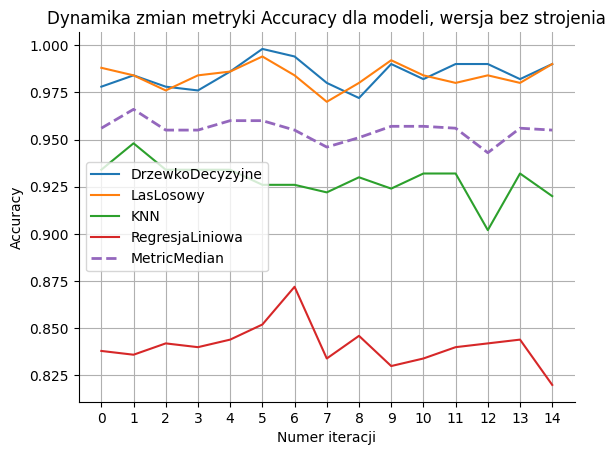

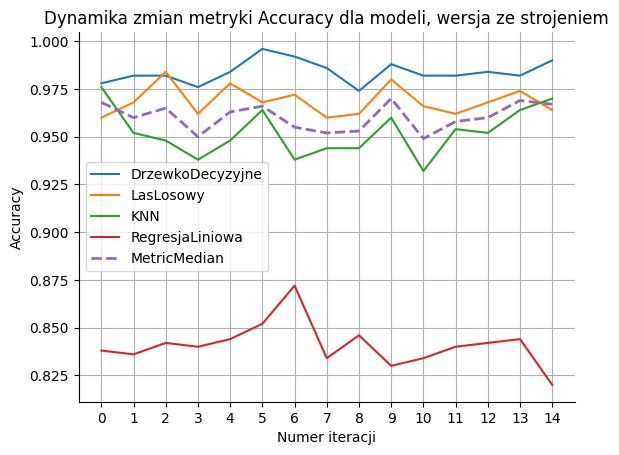

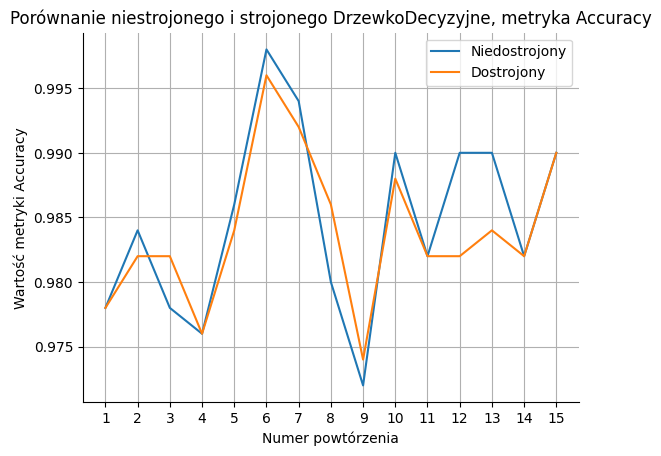

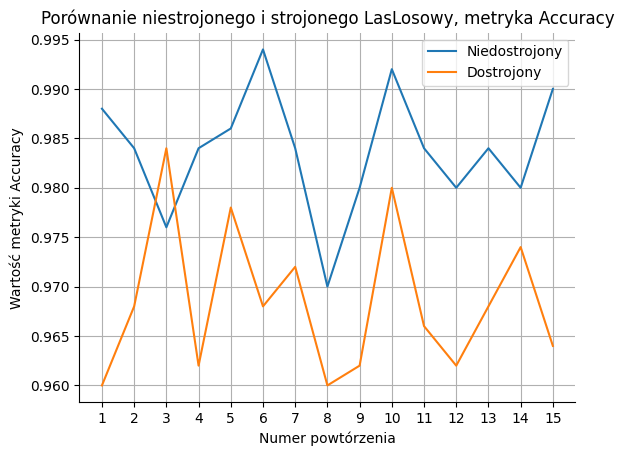

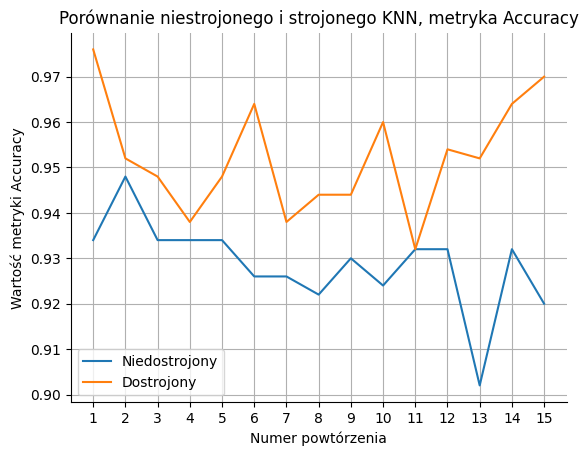

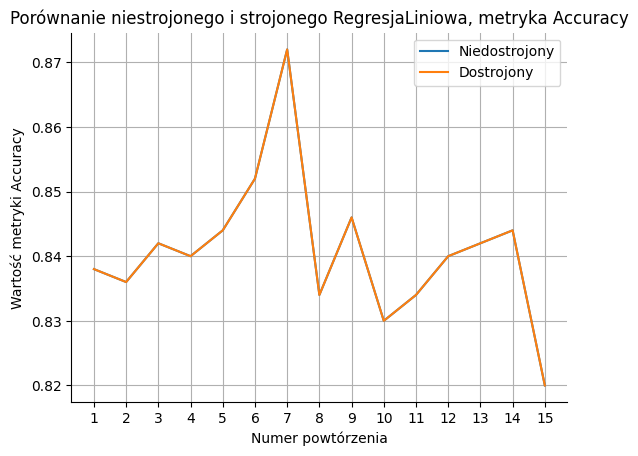

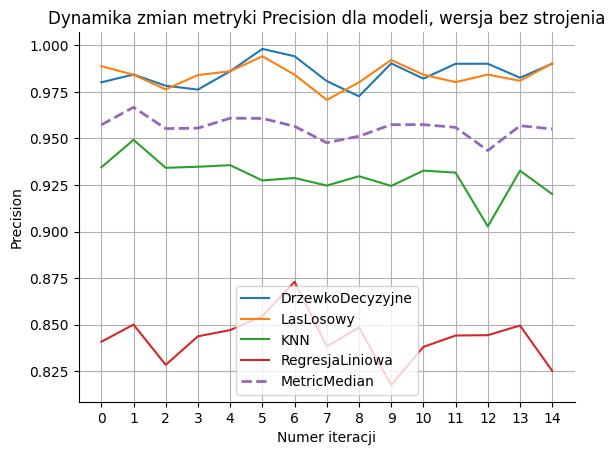

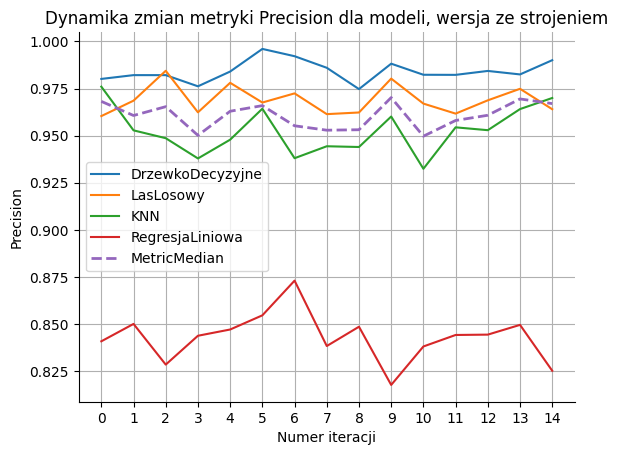

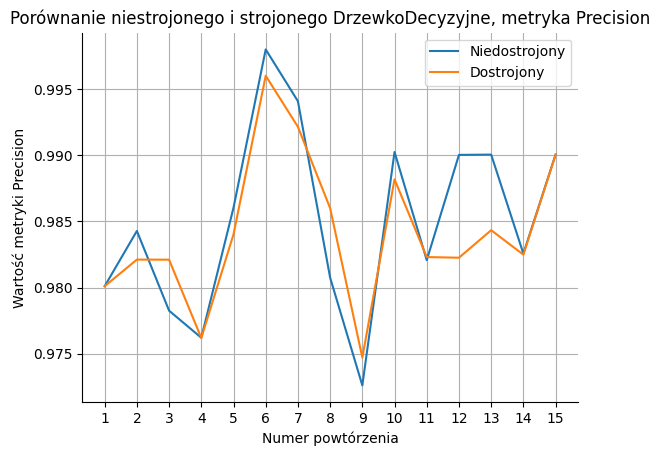

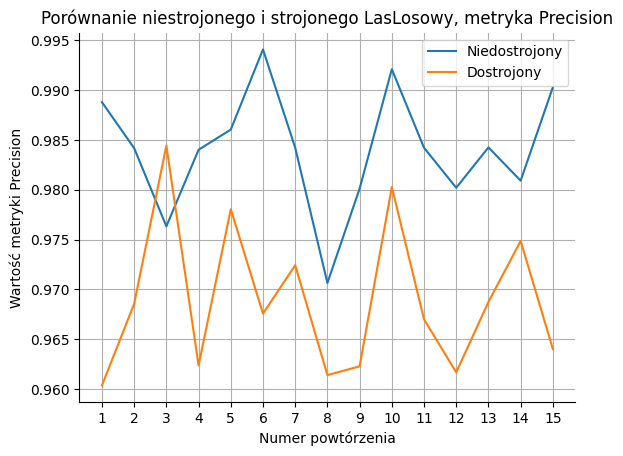

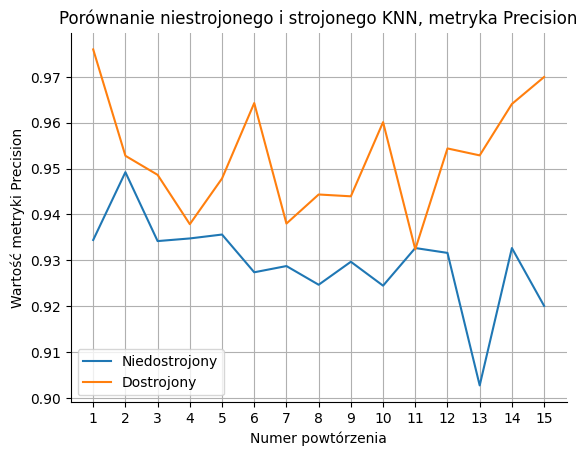

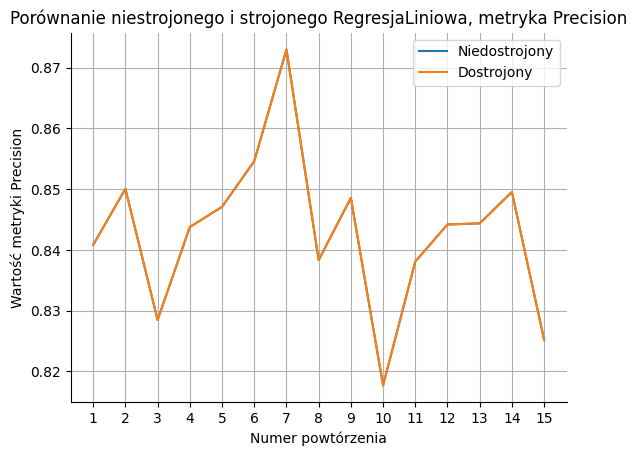

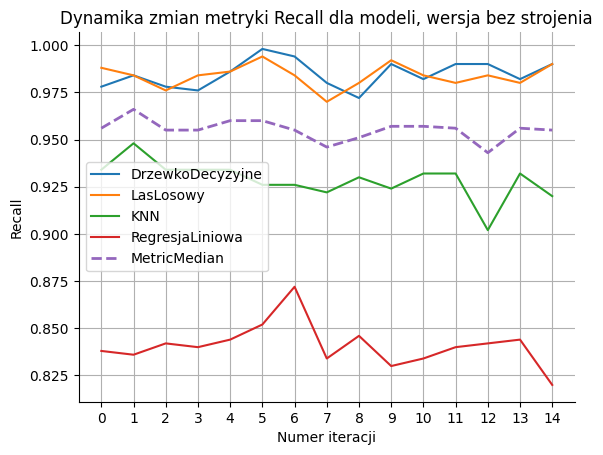

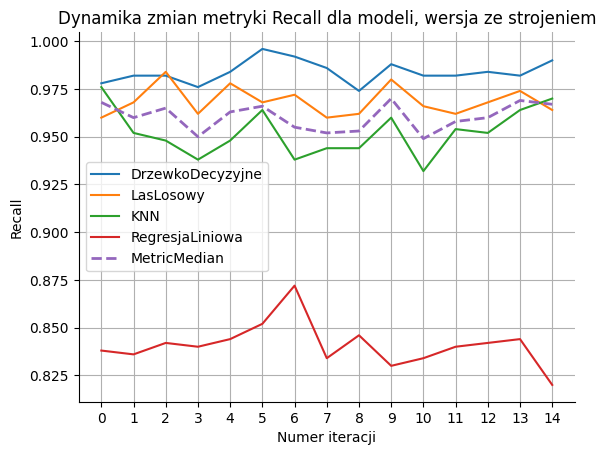

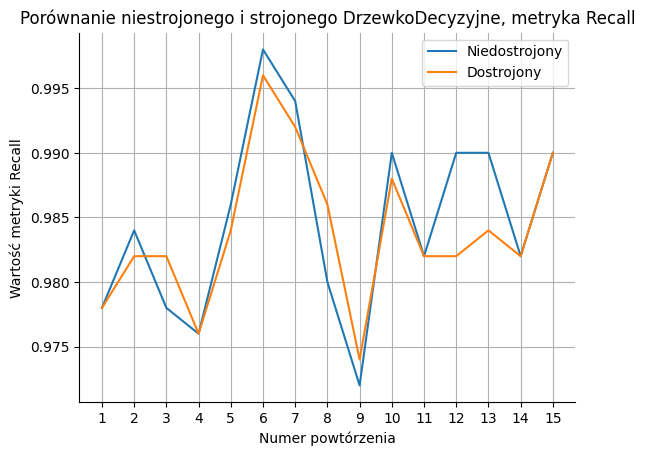

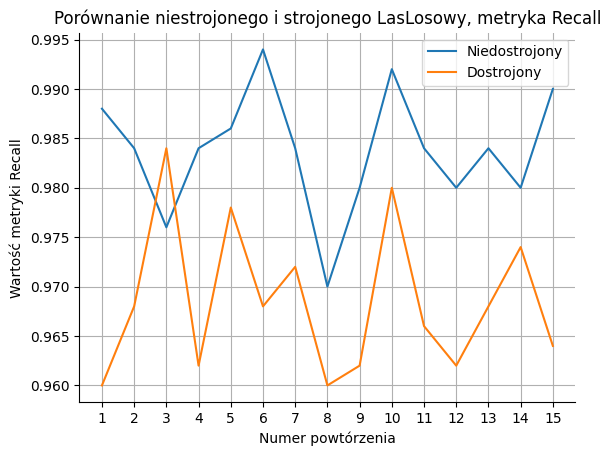

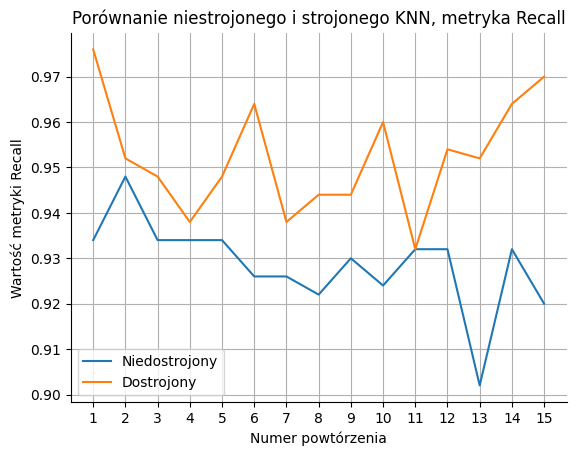

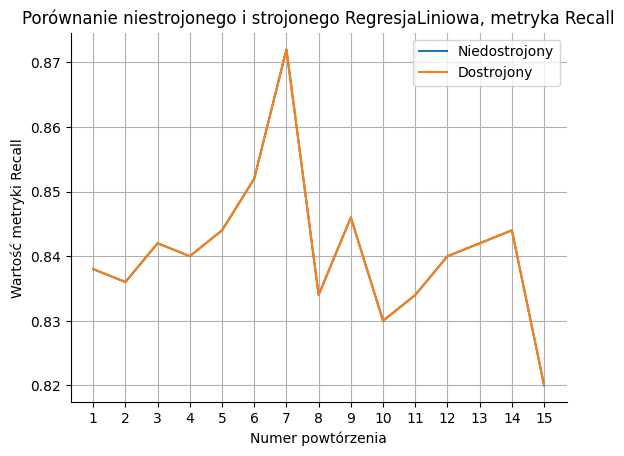

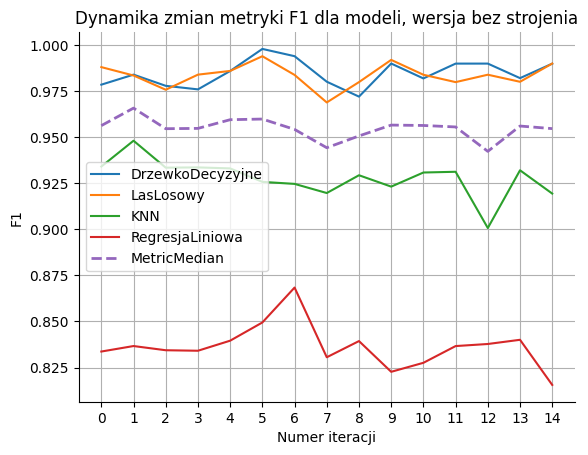

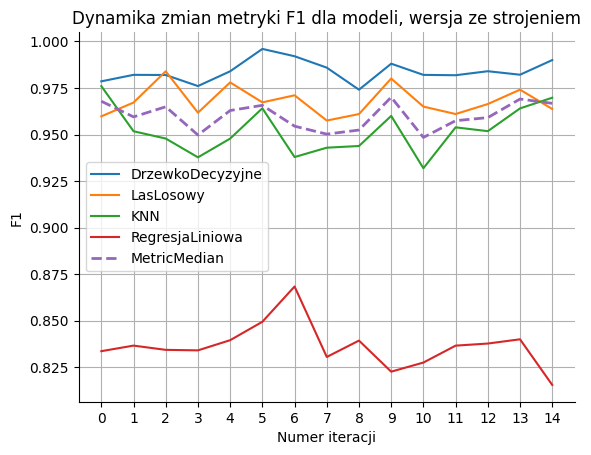

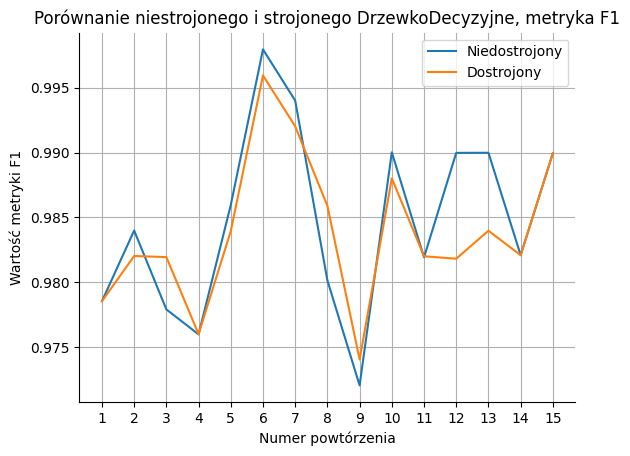

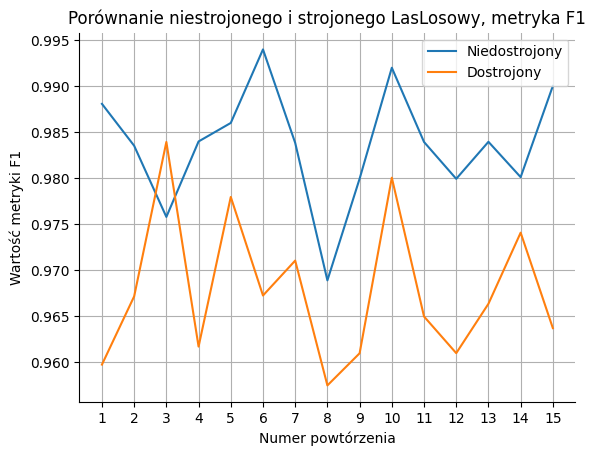

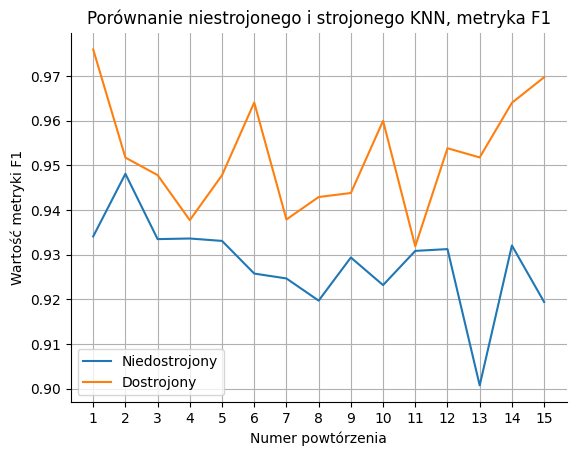

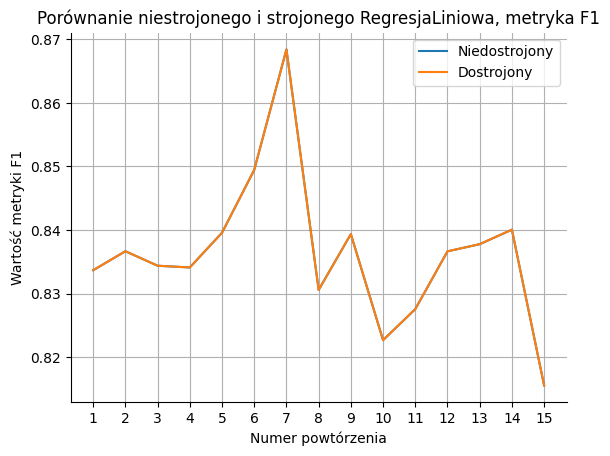

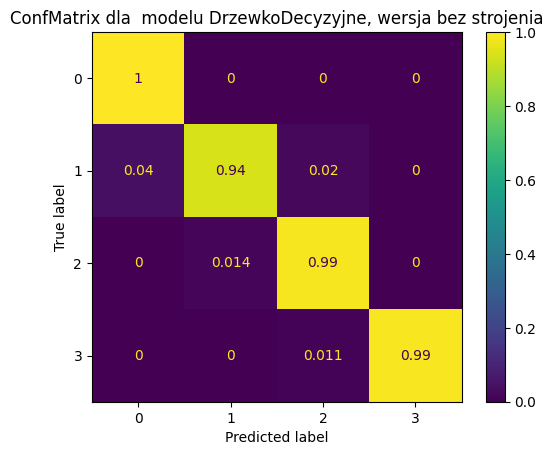

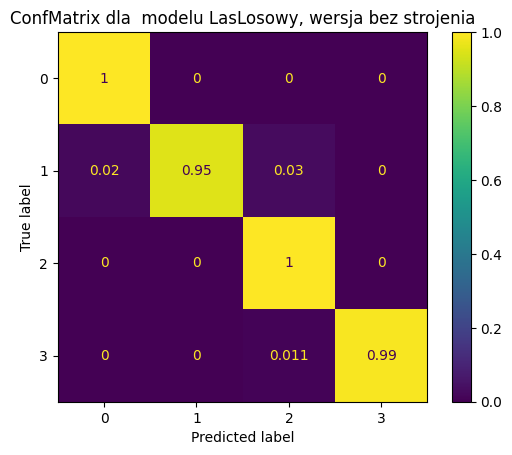

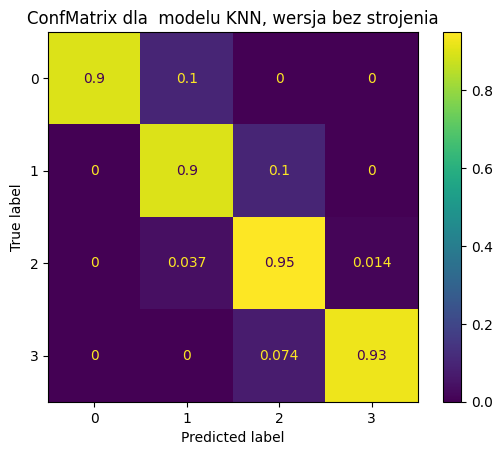

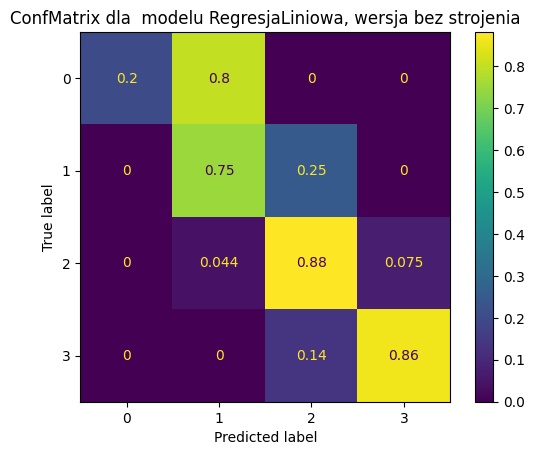

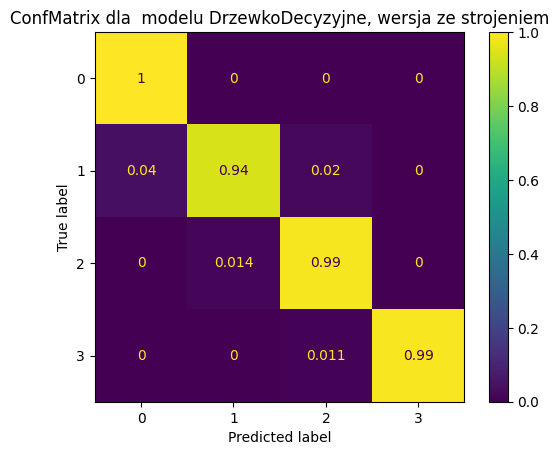

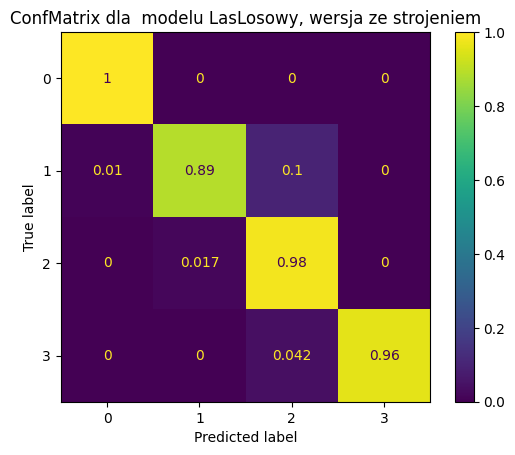

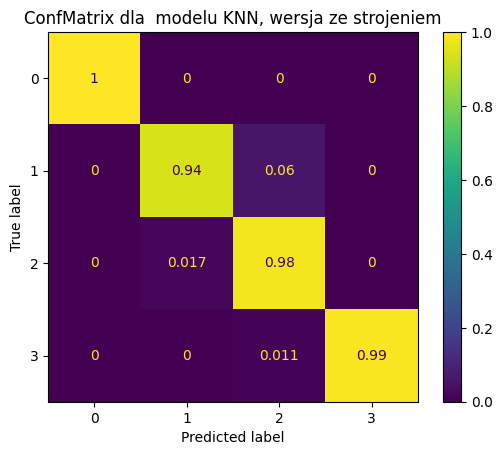

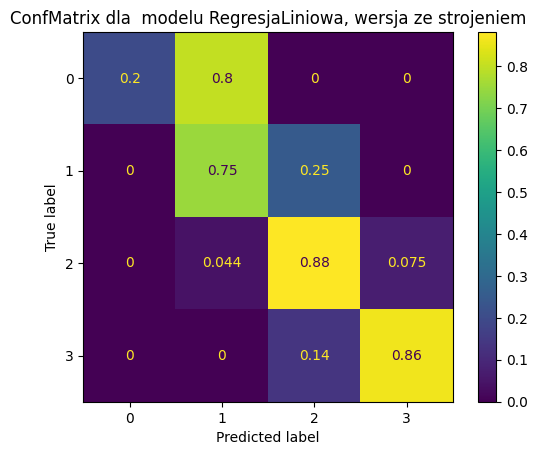

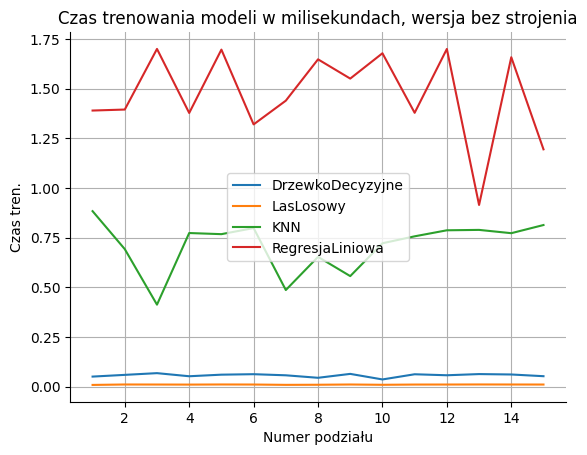

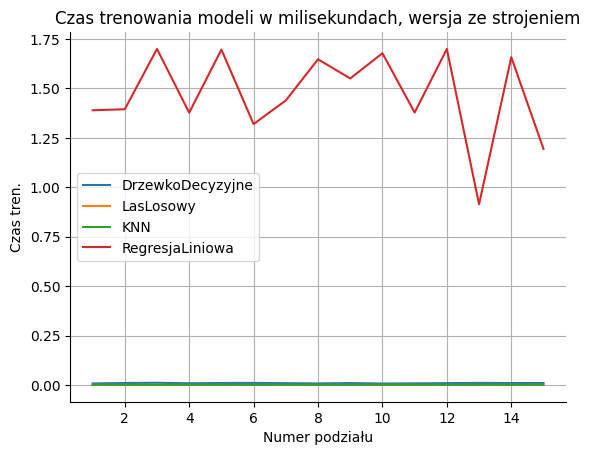

In [181]:
target_var: str = "CO2 Emissions(g/km)" #To jest nazwa zmiennej docelowej.
n_splits = 15
train_size = 0.75
test_size  = 1 - train_size


ManualEmissionAnalysis("CO2Emission.csv", ';', ',', dtypes = dtypes,  bins = [150, 200, 300], show_plots = False)


# Pytania badawcze przykładowe:
# 1) Jak liczba klas docelowych wpływa na skuteczność metod? Czy skuteczność modelu domyślnie maleje, jeżeli liczba klas docelowych wzrośnie?
# 2) Jak skuteczne są metody proste w porównaniu z metodami bardziej zaawansowanymi.
# 3) Jak istotne jest strojenie parametrów? Czy statyczne strojenie parametrów ulega dynamicznego strojeniu parametrów.
# 4) Jak istotny jest wybór optymalnych cech? Czy należy uwzględnić wszystkie względne? A może wystarczy tylko kilka cech?
# 5) Jak prezentuje się dokładnośc predykcji w stosunku do poszczególnych klas? Czy klasy rzadsze są łatwiej przewidywalne?
        



#Typy wyboru cech.
#1) Filtry, czyli  kasujemy cechy, niezależnie od modelu, na podstawie statystyk.
#2) wrappers, czyli metody, które są "owinięte" wokół pewnego modelu.
#3) embedded methods.


#Jak sobie poradzić ze zmiennymi kategorycznymi wysoko-kardynalnymi 
#1)Weź to przeczytaj: https://github.com/rasbt/mlxtend/issues/502

# Najpierw ustal klasy, które są determinowane przez regulacje. Będzie ich trzy
# Potem ustaw własne progi dla klas emisyjności, aby liczba klas wzrosła do 5.
# Beamer w latexu do robienia prezentacji.


Co dalej do roboty?:
2) Zamknięćie wszystkich funkcji w jedną, potężna funkcję.
4) Liczenie wskaźników dokładności, jeżeli selekcja cech była wybierana automatycznie.